In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import bets
import os
import glob
import datetime as dt
import time
import json
import requests
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
nba = bets.nba()
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder,BoxScoreSummaryV2,LeagueDashOppPtShot

In [4]:
def reload_table(table,filepath=None,data=None):
   
    try:
        nba.conn.execute('DROP TABLE {}'.format(table))
        nba.conn.commit()
    except:
        print('No table to delete, creating {}'.format(table))
    if filepath != None:
        file = open(filepath,'r').read()
        try:
            nba.conn.execute(file)
        except:
            '{} table already exists'.format(table)
    nba.insert_data(data,table)

### this needed done because I deleted data 

In [4]:

games = nba.get_games(nba.get_start_dates()[0],dt.datetime.today().strftime('%Y-%m-%d'))
games['season'] = ['{}-{}'.format(x[:4],int(x[2:4])+1) if int(x[5:7]) > 9 else '{}-{}'.format(int(x[:4])-1,x[2:4]) for x in games.GAME_DATE]

After starting to work through views, decided I needed to add season, wins to dataset, added below

In [79]:
files = glob.glob('data/pickle/teamlog*')
df = pd.DataFrame()
for file in files:
    df = pd.concat([df,pd.read_pickle(file)])
df = df.merge(gids,how='left', on = ['GAME_ID','TEAM_ID'])
df = df.drop_duplicates(subset=['GAME_ID','TEAM_ID'])
df['Total'] = df.filter([col for col in df.columns if col.find('PTS_') > -1]).sum(axis=1)
df['wins'] = np.where(df.groupby('GAME_ID').Total.transform('max') == df.Total, 1, 0)
df.drop(['Total','GAME_DATE'],axis=1,inplace=True)
df = df[df.groupby('GAME_ID').TEAM_ID.transform('nunique')==2]
df = df.merge(gids,how='left', on =['GAME_ID','TEAM_ID'])
addtdf = pd.DataFrame()
for pkl in tmpkl:
    addtdf = pd.concat([addtdf,pd.read_pickle(pkl)])
addtdf = addtdf.drop_duplicates(subset = ['game_id','TEAM_ID']).reset_index(drop=True)
addtdf.rename(columns = {'game_id':'GAME_ID'},inplace=True)
teamdf  = df.merge(addtdf,how='left',on=['TEAM_ID','GAME_ID'])

teamdf.filter(sqlord).shape

(16560, 26)

In [ ]:
gids = ['0022100038',
 '0021901272',
 '0022100144',
 '0021901300',
 '0021800828',
 '0022100905',
 '0022100890',
 '0022000589',
 '0021901261']
missing  = nba.get_summary(gids)

In [45]:
tmlog.drop(['game_date','season'],axis=1,inplace=True)

In [50]:
games.columns = [x.lower() for x in games.columns]
games['team_id'] = games.team_id.astype(str)

In [ ]:
tmlog.merge

In [70]:
final = pd.concat([teamdf,missing])

/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_95536/2880493318.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([teamdf,missing])


In [56]:
tmlog = pd.read_sql('select * from teamLog',nba.conn)

In [55]:
reload_table('teamLog',filepath='data/sql/createTeamLog.sql',data=tmlog.merge(games,how='left',on = ['game_id','team_id']).filter(logcols))

teamLog has been updated with 16,578 rows


### end reloading teamlog

Check Team Log information
1. all non-COVID years should have 1230 unique games (15 * 82) and same number of wins
   - somehow some games got messed up, pulled in game dataframe and correctd
2. check that all games have two teams (I believe 9 will only have one) - these had teams without inactives, needed to correct join

going to check above by going back through the api

In [19]:
tmO = pd.read_sql('''SELECT 
season, substr(game_date,6,2) as month, teamAbrv as team, rank() OVER(PARTITION BY team_id,season ORDER BY game_date) game_number,
count_inactive,
possessions,off_rate,
win, home,(q1_pts + q2_pts + q3_pts + q4_pts + ot1_pts + ot2_pts + ot3_pts + ot4_pts) as total,
pace, sht.*
from teamLog
JOIN teams USING (team_id)
left join (select team_id,game_id,
ra_fgm,ra_fga,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm ,abv_fga,ftm,fta,
oreb,oreb_contest,oreb_chances,oreb_chance_defer,avg_oreb_dist,pfd
from plyrLogs
group by game_id,team_id) sht USING (team_id,game_id)
''',nba.conn)

In [20]:
tmO

,season,month,team,game_number,count_inactive,possessions,off_rate,win,home,total,...,abv_fgm,abv_fga,ftm,fta,oreb,oreb_contest,oreb_chances,oreb_chance_defer,avg_oreb_dist,pfd
0,2017-18,10,ATL,1,3,102,114.7,1,0,117,...,0.0,0.0,3.0,4.0,2.0,2.0,5.0,0.0,3.2,4.0
1,2017-18,10,ATL,2,3,101,90.1,0,0,91,...,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0
2,2017-18,10,ATL,3,3,106,98.1,0,0,104,...,0.0,3.0,7.0,7.0,3.0,1.0,8.0,0.0,14.1,8.0
3,2017-18,10,ATL,4,3,102,91.2,0,0,93,...,0.0,0.0,2.0,2.0,4.0,3.0,6.0,0.0,3.7,1.0
4,2017-18,10,ATL,5,3,91,94.5,0,0,86,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,2023-24,04,CHA,78,5,97,121.6,0,1,118,...,4.0,7.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
16574,2023-24,04,CHA,79,5,101,103.0,0,1,104,...,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0
16575,2023-24,04,CHA,80,4,98,117.3,1,0,115,...,2.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
16576,2023-24,04,CHA,81,6,100,98.0,0,0,98,...,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0


In [6]:
pd.read_sql('select * from teamLog',nba.conn)

,game_id,game_date,team_id,inactive,count_inactive,assist_pct,off_rate,def_rate,pace,possessions,...,q1_pts,q2_pts,q3_pts,q4_pts,ot1_pts,ot2_pts,ot3_pts,ot4_pts,win,season
0,0022100082,2021-10-30,1610612737,"1630536,1630168",2.0,0.667,94.9,122.0,99.5,99,...,15,31,23,25,NaN,NaN,NaN,NaN,0,2021-22
1,0022100082,2021-10-30,1610612755,"1627732,1630203,1630565,1630531",4.0,0.522,122.0,94.9,99.5,100,...,28,32,29,33,NaN,NaN,NaN,NaN,1,2021-22
2,0021701184,2018-04-06,1610612737,"203145,203705,1628510,1627098,202379,1628463,2...",7.0,0.632,102.0,97.0,100.5,101,...,21,31,29,22,NaN,NaN,NaN,NaN,1,2017-18
3,0021701184,2018-04-06,1610612764,"202322,1626191,101133",3.0,0.514,97.0,102.0,100.5,100,...,22,26,29,20,NaN,NaN,NaN,NaN,0,2017-18
4,0021800402,2018-12-11,1610612745,"2546,1627737,1627753,1629053,202688",5.0,0.524,118.1,113.0,93.0,94,...,27,24,30,30,NaN,NaN,NaN,NaN,1,2018-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,0022100890,2020-08-04,1610612738,None,NaN,0.609,125.2,101.0,104.0,103,...,35,32,30,32,NaN,NaN,NaN,NaN,1,2019-20
16574,0022000589,2020-08-04,1610612764,"202397,1628418",2.0,0.581,105.3,110.6,113.0,113,...,33,32,30,24,NaN,NaN,NaN,NaN,0,2019-20
16575,0022000589,2020-08-04,1610612749,None,NaN,0.767,110.6,105.3,113.0,113,...,36,28,30,31,NaN,NaN,NaN,NaN,1,2019-20
16576,0021901261,2020-08-04,1610612757,None,NaN,0.462,106.8,100.0,102.5,103,...,29,32,25,24,NaN,NaN,NaN,NaN,1,2019-20


In [61]:
tmD = pd.read_sql('''select 
season, substr(sht.game_date,6,2) as month, teamAbrv as team, rank() OVER(PARTITION BY team_id,season ORDER BY sht.game_date) game_number,
count_inactive,def_rate,
pace * 2 - possessions as possessionsAllowed, round((pace * 2 - possessions) * def_rate / 100) as points_allowed,
win, home, sht.*
from  shotsAllowed sht
JOIN teamLog log USING (team_id,game_id)
JOIN teams tms USING (team_id)
left join (select team_id,game_id,
dreb,dreb_contest,dreb_chances,dreb_chance_defer,avg_dreb_dist,pf
from plyrLogs
group by game_id,team_id) ply USING (game_id,team_id)

''',nba.conn)

In [63]:
tmD.groupby('season').game_id.nunique()

season
2017-18    1222
2018-19    1226
2019-20    1053
2020-21    1079
2021-22    1225
2022-23    1226
2023-24    1219
Name: game_id, dtype: int64

In [64]:
tmO.groupby('season').game_id.nunique()

season
2017-18    1222
2018-19    1225
2019-20    1059
2020-21    1079
2021-22    1225
2022-23    1212
2023-24    1189
Name: game_id, dtype: int64

In [65]:
tmlog.groupby('season').game_id.nunique()

season
2017-18    1230
2018-19    1230
2019-20    1059
2020-21    1080
2021-22    1230
2022-23    1230
2023-24    1230
Name: game_id, dtype: int64

In [66]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,plyrLogs,plyrLogs,4708,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
3,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
4,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
5,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."


### We have missing player data needed to complete the set, will use season game counts to verify

In [67]:
plyr = pd.read_sql('select * from plyrLogs',nba.conn)

In [72]:
plyr['season'] = ['{}-{}'.format(x[:4],int(x[2:4])+1) if int(x[5:7]) > 9 else '{}-{}'.format(int(x[:4])-1,x[2:4]) for x in plyr.game_date]

In [74]:
plyr.groupby('season').game_id.nunique()

season
2017-18    1222
2018-19    1226
2019-20    1053
2020-21    1080
2021-22    1229
2022-23    1212
2023-24    1189
Name: game_id, dtype: int64

In [112]:
missplyr = list(set(tmlog.game_date.unique()).difference(set(plyr.game_date.unique())))

In [113]:
missplyr

['2024-03-09', '2024-04-14', '2022-11-25', '2023-11-24', '2023-11-25']

In [434]:
nba.update_player_log(['2022-11-25'])

started player logs at 20:58
getting first buckets : at 20:58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:41<00:00,  2.93s/it]


	completed at 20:59
started rebounds at 20:59
ended rebounds at 20:59
starting advanced box at 20:59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:38<00:00,  2.76s/it]


completed adv box at 21:00
start player shots at 21:00


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

completed player shots at 21:00
plyrLogs has been updated with 293 rows


,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fga,paint_fgm,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga
0,201142,1610612751,0022200276,2022-11-25,38.821667,3,4,9,8,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1628392,1610612752,0022200274,2022-11-25,16.900000,2,2,2,2,0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1628470,1610612756,0022200283,2022-11-25,33.146667,0,0,7,1,1,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0
3,1626195,1610612740,0022200279,2022-11-25,12.000000,2,2,5,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1629641,1610612759,0022200282,2022-11-25,21.516667,1,2,4,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1630168,1610612737,0022200278,2022-11-25,32.700000,4,6,11,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289,1629627,1610612740,0022200279,2022-11-25,30.000000,2,2,5,4,1,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
290,1630172,1610612741,0022200281,2022-11-25,31.966667,0,0,6,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0
291,1629012,1610612762,0022200284,2022-11-25,24.150000,4,4,1,7,0,...,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [435]:

pdf = pd.read_sql('select * from plyrLogs',nba.conn)

In [436]:
pdf['season'] = ['{}-{}'.format(x[:4],int(x[2:4])+1) if int(x[5:7]) > 9 else '{}-{}'.format(int(x[:4])-1,x[2:4]) for x in  pdf.game_date]

In [437]:
print('total:{}'.format(pdf.groupby('season').game_id.nunique().sum()))
pdf.groupby('season').game_id.nunique()

total:8289


season
2017-18    1230
2018-19    1230
2019-20    1059
2020-21    1080
2021-22    1230
2022-23    1230
2023-24    1230
Name: game_id, dtype: int64

In [121]:
pdf

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,ra_fga,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga,season
0,203463,1610612763,0021701227,2018-04-11,31.716667,4,4,4,3,1,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,2017-18
1,203994,1610612757,0021701229,2018-04-11,29.533333,1,5,9,3,3,...,9.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-18
2,202355,1610612748,0021701221,2018-04-11,22.383333,0,0,12,2,0,...,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-18
3,201950,1610612740,0021701226,2018-04-11,34.100000,1,1,3,7,6,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2017-18
4,203459,1610612751,0021701219,2018-04-11,25.833333,1,1,7,3,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,10.0,2017-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143320,1630581,1610612760,0022200281,2022-11-25,37.500000,0,0,13,9,5,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022-23
143321,1628991,1610612763,0022200279,2022-11-25,21.800000,6,7,4,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2022-23
143322,1630177,1610612766,0022200272,2022-11-25,25.555000,5,6,7,3,1,...,3.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,2022-23
143323,203924,1610612757,0022200274,2022-11-25,40.296667,21,28,1,2,2,...,8.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,4.0,2022-23


In [321]:
pdf.game_id.nunique()

8225

In [326]:
mspnt = gids[~gids.GAME_ID.isin(paint.GAME_ID.unique())].GAME_DATE.unique()

In [327]:
missingShots = nba.get_player_shot_spots(mspnt)

start player shots at 20:00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:53<00:00,  3.91s/it]

completed player shots at 20:02


In [329]:
missingShots.filter(cols)

,GAME_DATE,TEAM_ID,PLAYER_ID
0,2023-03-28,1610612760,1630598
1,2023-03-28,1610612753,1629678
2,2023-03-28,1610612738,201143
3,2023-03-28,1610612760,1630197
4,2023-03-28,1610612764,1630264
...,...,...,...
60,2021-01-26,1610612752,1629033
61,2021-01-26,1610612737,203503
62,2021-01-26,1610612737,1629027
63,2021-01-26,1610612762,1628962


In [137]:
plog['season'] = ['{}-{}'.format(x[:4],int(x[2:4])+1) if int(x[5:7]) > 9 else '{}-{}'.format(int(x[:4])-1,x[2:4]) for x in  plog.GAME_DATE]

In [138]:
plog.groupby('season').GAME_ID.nunique()

season
2017-18    1230
2018-19    1230
2019-20    1059
2020-21    1080
2021-22    1230
2022-23    1230
2023-24    1230
Name: GAME_ID, dtype: int64

In [124]:
msgm = plog[~plog.GAME_ID.isin(pdf.game_id.unique())].GAME_DATE.unique()


In [286]:
shtFiles = glob.glob('data/pickle/plyrShots20*')

In [343]:
missingShots = missingShots[['GAME_DATE','TEAM_ID','PLAYER_ID','paint_fgm','paint_fga']]

### Missing shots in the paint and needed added to the dataset

In [344]:
paint = pd.DataFrame()
cols = ['GAME_DATE','TEAM_ID','PLAYER_ID','In_The_Paint_(Non_RA)_FGM','In_The_Paint_(Non_RA)_FGA']
for file in shtFiles:
    temp = pd.DataFrame([plyr for team in pd.read_pickle(file)for plyr in team])
    paint = pd.concat([paint,temp.filter(cols)]) 
paint.columns = missingShots.columns
paint = pd.concat([paint,missingShots])
paint = paint.merge(gids,how='left',on=['GAME_DATE','TEAM_ID'])

In [362]:
paint.columns = [col.lower() for col in paint.columns]
paint['team_id'] = paint.team_id.astype(str)
paint['player_id'] = paint.player_id.astype(str)

In [367]:
sqlord = ['player_id', 'team_id', 'game_id', 'game_date', 'min', 'ftm', 'fta',
       'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts',
       'plus_minus', 'dd2', 'td3', 'offensiveRating', 'defensiveRating',
       'usagePercentage', 'pace', 'possessions', 'team_first', 'game_first',
       'oreb', 'oreb_contest', 'oreb_chances', 'oreb_chance_defer',
       'avg_oreb_dist', 'dreb', 'dreb_contest', 'dreb_chances',
       'dreb_chance_defer', 'avg_dreb_dist', 'ra_fgm', 'ra_fga','paint_fgm','paint_fga', 'mid_fgm',
       'mid_fga', 'lc_fgm', 'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm',
       'abv_fga']

In [373]:
plyrUp = plyr.merge(paint,how='left',on=['player_id','game_id','team_id','game_date']).filter(sqlord)

In [374]:
plyrUp

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fgm,paint_fga,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga
0,203463,1610612763,0021701227,2018-04-11,31.716667,4,4,4,3,1,...,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0
1,203994,1610612757,0021701229,2018-04-11,29.533333,1,5,9,3,3,...,1.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,202355,1610612748,0021701221,2018-04-11,22.383333,0,0,12,2,0,...,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201950,1610612740,0021701226,2018-04-11,34.100000,1,1,3,7,6,...,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,203459,1610612751,0021701219,2018-04-11,25.833333,1,1,7,3,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143027,1630193,1610612752,0022100578,2022-01-06,25.033333,1,1,2,3,2,...,1.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,5.0
143028,202066,1610612740,0022100580,2022-01-06,18.551667,0,0,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
143029,202683,1610612738,0022100578,2022-01-06,11.733333,0,0,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143030,1629634,1610612763,0022100579,2022-01-06,21.650000,1,2,4,2,3,...,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [433]:
rbs = nba.get_rebounds(['2022-11-25'])
adv = nba.get_advanced_box(['2022-11-25'])
shts = nba.get_player_shot_spots(['2022-11-25'])

started rebounds at 20:57
ended rebounds at 20:57
starting advanced box at 20:57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:46<00:00,  3.32s/it]


completed adv box at 20:58
start player shots at 20:58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]

completed player shots at 20:58


In [377]:
lg = plog[plog.GAME_DATE.isin(msgm)]

In [378]:
lg.shape

(4849, 20)

In [379]:
lgrbs = lg.merge(rbs,how='left',on=['GAME_ID','GAME_DATE','TEAM_ID','PLAYER_ID'])

In [380]:
lrsht = lgrbs.merge(shts,how='left',on= ['TEAM_ID','PLAYER_ID','GAME_DATE'])
adsbk = adv.merge(bskt,how='left',on=['PLAYER_ID','GAME_ID'])

In [381]:
final = lrsht.merge(adsbk,how='left',on=['PLAYER_ID','GAME_ID'])

In [382]:
final

,PLAYER_ID,TEAM_ID,GAME_ID,GAME_DATE,MIN,FTM,FTA,REB,AST,TOV,...,rc_fga,abv_fgm,abv_fga,offensiveRating,defensiveRating,usagePercentage,pace,possessions,team_first,game_first
0,1630163,1610612766,0022100132,2021-11-05,30.700000,2,2,3,13,2,...,1.0,4.0,7.0,126.9,150.7,0.236,104.76,67.0,NaN,NaN
1,203078,1610612764,0022100126,2021-11-05,27.300000,3,3,3,7,5,...,0.0,0.0,1.0,124.6,98.2,0.277,99.34,57.0,1.0,1.0
2,1628991,1610612763,0022100126,2021-11-05,24.650000,4,4,9,2,3,...,0.0,1.0,6.0,77.4,117.3,0.306,102.23,53.0,NaN,NaN
3,1627832,1610612761,0022100127,2021-11-05,37.023333,2,3,6,6,3,...,0.0,1.0,3.0,105.7,114.9,0.253,88.81,70.0,NaN,NaN
4,1630558,1610612758,0022100132,2021-11-05,24.833333,3,3,4,4,1,...,0.0,4.0,5.0,126.4,94.5,0.224,104.38,53.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,1628427,1610612743,0022200639,2023-01-13,16.266667,2,2,4,0,0,...,0.0,1.0,1.0,112.5,117.6,0.100,97.38,32.0,NaN,NaN
4845,1631094,1610612753,0022200638,2023-01-13,31.170000,2,4,4,3,4,...,0.0,1.0,5.0,102.9,107.1,0.297,106.26,68.0,NaN,NaN
4846,201599,1610612743,0022200639,2023-01-13,26.483333,0,0,6,3,3,...,NaN,0.0,0.0,129.4,113.7,0.132,92.44,51.0,1.0,0.0
4847,1628971,1610612743,0022200639,2023-01-13,24.516667,4,5,3,4,0,...,0.0,1.0,3.0,122.4,106.0,0.155,96.91,49.0,NaN,NaN


In [383]:
final.drop(['season'],axis=1,inplace=True)
final.columns = ['player_id','team_id','game_id','game_date','min','ftm','fta','reb','ast','tov','stl','blk','blka','pf',
         'pfd','pts','plus_minus','dd2','td3','oreb','oreb_contest','oreb_chances','oreb_chance_defer','avg_oreb_dist','dreb',
         'dreb_contest','dreb_chances','dreb_chance_defer','avg_dreb_dist','ra_fgm','ra_fga', 'paint_fgm', 'paint_fga','mid_fgm',
         'mid_fga', 'lc_fgm','lc_fga', 'rc_fgm','rc_fga','abv_fgm', 'abv_fga', 'offensiveRating','defensiveRating',
         'usagePercentage', 'pace', 'possessions','team_first', 'game_first']

In [385]:
final[~final.game_id.isin(pdf.game_id.unique())].fillna(0)

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,rc_fga,abv_fgm,abv_fga,offensiveRating,defensiveRating,usagePercentage,pace,possessions,team_first,game_first
0,1630163,1610612766,0022100132,2021-11-05,30.700000,2,2,3,13,2,...,1.0,4.0,7.0,126.9,150.7,0.236,104.76,67.0,0.0,0.0
4,1630558,1610612758,0022100132,2021-11-05,24.833333,3,3,4,4,1,...,0.0,4.0,5.0,126.4,94.5,0.224,104.38,53.0,0.0,0.0
27,1626158,1610612758,0022100132,2021-11-05,33.261667,5,7,20,2,4,...,0.0,0.0,0.0,134.7,100.0,0.235,106.07,72.0,0.0,0.0
29,1627741,1610612758,0022100132,2021-11-05,30.050000,0,0,3,4,2,...,0.0,0.0,0.0,137.9,115.2,0.274,105.42,66.0,0.0,0.0
31,203486,1610612766,0022100132,2021-11-05,21.838333,1,5,6,4,0,...,0.0,0.0,0.0,104.2,128.6,0.077,106.60,48.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814,1630237,1610612744,0022200635,2023-01-13,24.266667,0,0,5,2,1,...,0.0,3.0,3.0,144.8,115.8,0.121,113.74,58.0,0.0,0.0
4816,1628978,1610612744,0022200635,2023-01-13,25.283333,4,4,7,5,1,...,0.0,4.0,10.0,146.6,112.1,0.290,110.11,58.0,0.0,0.0
4833,1629641,1610612759,0022200635,2023-01-13,18.083333,3,8,1,2,0,...,0.0,0.0,1.0,100.0,105.0,0.208,106.18,40.0,0.0,0.0
4835,203926,1610612759,0022200635,2023-01-13,22.183333,3,4,2,1,0,...,0.0,0.0,2.0,98.1,145.3,0.164,115.76,54.0,1.0,0.0


In [386]:
new = pd.concat([plyrUp,final])

In [387]:
new

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fgm,paint_fga,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga
0,203463,1610612763,0021701227,2018-04-11,31.716667,4,4,4,3,1,...,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0
1,203994,1610612757,0021701229,2018-04-11,29.533333,1,5,9,3,3,...,1.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,202355,1610612748,0021701221,2018-04-11,22.383333,0,0,12,2,0,...,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201950,1610612740,0021701226,2018-04-11,34.100000,1,1,3,7,6,...,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,203459,1610612751,0021701219,2018-04-11,25.833333,1,1,7,3,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,1628427,1610612743,0022200639,2023-01-13,16.266667,2,2,4,0,0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4845,1631094,1610612753,0022200638,2023-01-13,31.170000,2,4,4,3,4,...,2.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,5.0
4846,201599,1610612743,0022200639,2023-01-13,26.483333,0,0,6,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
4847,1628971,1610612743,0022200639,2023-01-13,24.516667,4,5,3,4,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0


In [389]:
new.shape

(147881, 48)

In [394]:
pd.read_sql('select * from plyrLogs',nba.conn)

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fga,paint_fgm,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga
0,203463,1610612763,0021701227,2018-04-11,31.716667,4,4,4,3,1,...,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0
1,203994,1610612757,0021701229,2018-04-11,29.533333,1,5,9,3,3,...,1.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,202355,1610612748,0021701221,2018-04-11,22.383333,0,0,12,2,0,...,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201950,1610612740,0021701226,2018-04-11,34.100000,1,1,3,7,6,...,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,203459,1610612751,0021701219,2018-04-11,25.833333,1,1,7,3,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143028,202066,1610612740,0022100580,2022-01-06,18.551667,0,0,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
143029,202683,1610612738,0022100578,2022-01-06,11.733333,0,0,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143030,1629634,1610612763,0022100579,2022-01-06,21.650000,1,2,4,2,3,...,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143031,1630541,1610612744,0022100580,2022-01-06,23.061667,4,4,5,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0


In [420]:
new['player_id'] = new.player_id.astype(str)

In [424]:
new = new.drop_duplicates(subset=['player_id','game_id'])

In [425]:
nba.insert_data(new,'plyrLogs')

plyrLogs has been updated with 145,033 rows


#### ------------------------------------------------------------------End of Update--------------------------------------------------------------------------------------

In [5]:
tmd = pd.read_sql('select * from team_def',nba.conn)

In [6]:
tmd.groupby('season').game_id.nunique()

season
2017-18    1222
2018-19    1226
2019-20    1053
2020-21    1079
2021-22    1225
2022-23    1226
2023-24    1219
Name: game_id, dtype: int64

In [7]:
shtAllowed = pd.read_sql('select * from shotsAllowed',nba.conn)

In [8]:
shtAllowed['season'] = ['{}-{}'.format(x[:4],int(x[2:4])+1) if int(x[5:7]) > 9 else '{}-{}'.format(int(x[:4])-1,x[2:4]) for x in  shtAllowed.game_date]

In [9]:
shtAllowed.groupby('season').game_id.nunique()

season
2017-18    1222
2018-19    1226
2019-20    1053
2020-21    1079
2021-22    1225
2022-23    1226
2023-24    1219
Name: game_id, dtype: int64

In [11]:
missShot = games[~games.GAME_ID.isin(shtAllowed.game_id.unique())].GAME_DATE.unique()

In [160]:
missShot

array(['2024-04-14', '2024-03-09', '2024-01-05', '2023-12-22',
       '2023-12-07', '2023-04-08', '2023-04-06', '2023-01-19',
       '2023-01-13', '2022-01-06', '2021-11-05', '2021-01-25',
       '2020-03-08', '2020-03-04', '2020-02-09', '2020-01-24',
       '2019-12-14', '2019-12-12', '2019-01-19', '2019-01-17',
       '2018-12-15', '2018-12-13', '2018-03-13', '2018-03-09',
       '2018-01-11', '2017-12-16', '2017-12-09', '2017-12-07',
       '2017-11-18', '2017-10-26'], dtype=object)

### looking at some data there seems to be data not available, we will skip those dates for now

In [ ]:
msShot = pd.DataFrame()
for date in missShot:
    nba.update_shots_allowed([date])

##will have to run individually, these will run fine, just need to get the data to add


In [90]:
import time

In [92]:
sleep = ['sleep','staySleep','still sleeping','night night','sleepy bear']


In [163]:
iters = 0
for i in range(iters):
    if i % 5 == 0:
        print(i,sleep[np.random.choice(range(0,len(sleep)))])
    time.sleep(60)
op = nba.get_opp_dribble_shot(missShot)

0 night night
5 night night
10 still sleeping
15 staySleep
20 sleep
25 staySleep
30 staySleep
35 staySleep
40 sleep
45 night night
50 sleepy bear
55 sleepy bear
60 sleep


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:30<00:00,  1.01s/it]


In [172]:
drb

,TEAM_ID,GAME_DATE,0_Dribbles_FG2M,0_Dribbles_FG2A,0_Dribbles_FG3M,0_Dribbles_FG3A,1_Dribble_FG2M,1_Dribble_FG2A,1_Dribble_FG3M,1_Dribble_FG3A,...,2_Dribbles_FG3M,2_Dribbles_FG3A,3-6_Dribbles_FG2M,3-6_Dribbles_FG2A,3-6_Dribbles_FG3M,3-6_Dribbles_FG3A,7+_Dribbles_FG2M,7+_Dribbles_FG2A,7+_Dribbles_FG3M,7+_Dribbles_FG3A
0,1610612737,2024-04-14,18.0,21.0,15.0,29.0,7.0,11.0,1.0,1.0,...,0.0,0.0,11.0,17.0,2.0,3.0,4.0,8.0,1.0,3.0
1,1610612738,2024-04-14,13.0,18.0,10.0,23.0,4.0,6.0,3.0,6.0,...,0.0,3.0,8.0,17.0,1.0,5.0,4.0,11.0,0.0,1.0
2,1610612739,2024-04-14,8.0,11.0,15.0,30.0,5.0,7.0,1.0,1.0,...,1.0,4.0,9.0,19.0,1.0,2.0,1.0,7.0,1.0,3.0
3,1610612740,2024-04-14,17.0,20.0,7.0,16.0,5.0,11.0,1.0,3.0,...,1.0,1.0,7.0,14.0,2.0,5.0,3.0,7.0,0.0,4.0
4,1610612741,2024-04-14,10.0,11.0,11.0,24.0,3.0,7.0,0.0,4.0,...,0.0,2.0,13.0,22.0,0.0,0.0,4.0,12.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1610612742,2017-10-26,8.0,14.0,6.0,23.0,3.0,5.0,0.0,1.0,...,1.0,1.0,3.0,7.0,0.0,3.0,1.0,4.0,3.0,6.0
4,1610612746,2017-10-26,6.0,17.0,10.0,23.0,6.0,9.0,0.0,0.0,...,0.0,2.0,2.0,10.0,3.0,5.0,4.0,11.0,1.0,1.0
5,1610612757,2017-10-26,11.0,16.0,3.0,14.0,1.0,3.0,1.0,4.0,...,1.0,2.0,2.0,6.0,2.0,5.0,7.0,12.0,2.0,3.0
6,1610612758,2017-10-26,8.0,12.0,11.0,25.0,2.0,3.0,0.0,0.0,...,1.0,3.0,6.0,16.0,1.0,3.0,3.0,7.0,0.0,1.0


In [190]:
drb.TEAM_ID = drb.TEAM_ID.astype(str)

In [192]:
drbSpot = spots.merge(drb,how='left',on=['GAME_DATE','TEAM_ID'])

In [ ]:
shots

In [198]:
op = pd.DataFrame()
for date in missShot:
    try:
        op = pd.concat([op,nba.get_open_shot_allowed([date])])
    except:
        print('{} Did not have data'.format(date))
        

  0%|                                                                                                                                                       | 0/1 [00:00<?, ?it/s]


2024-03-09 Did not have data


  0%|                                                                                                                                                       | 0/1 [00:01<?, ?it/s]


2022-01-06 Did not have data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


In [200]:
op.TEAM_ID = op.TEAM_ID.astype(str)

In [201]:
finalShot =  drbSpot.merge(op,how='left',on=['GAME_DATE','TEAM_ID'])

In [203]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
3,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
4,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
5,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."


In [207]:
sqlord = ['TEAM_ID', 'GAME_DATE', 'GAME_ID', 'Restricted_Area_OPP_FGM', 'Restricted_Area_OPP_FGA',
                  'In_The_Paint_(Non_RA)_OPP_FGM', 'In_The_Paint_(Non_RA)_OPP_FGA',
                  'Mid_Range_OPP_FGM', 'Mid_Range_OPP_FGA', 'Left_Corner_3_OPP_FGM',
                  'Left_Corner_3_OPP_FGA', 'Right_Corner_3_OPP_FGM',
                  'Right_Corner_3_OPP_FGA', 'Above_the_Break_3_OPP_FGM',
                  'Above_the_Break_3_OPP_FGA', 'Corner_3_OPP_FGM', 'Corner_3_OPP_FGA', 'WIDEOPEN_FG2M', 'WIDEOPEN_FG2A',
                  'WIDEOPEN_FG3M', 'WIDEOPEN_FG3A', 'OPEN_FG2M', 'OPEN_FG2A', 'OPEN_FG3M', 'OPEN_FG3A',
                  '0_Dribbles_FG2M', '0_Dribbles_FG2A', '0_Dribbles_FG3M',
                  '0_Dribbles_FG3A', '1_Dribble_FG2M', '1_Dribble_FG2A', '1_Dribble_FG3M',
                  '1_Dribble_FG3A', '2_Dribbles_FG2M', '2_Dribbles_FG2A',
                  '2_Dribbles_FG3M', '2_Dribbles_FG3A', '3-6_Dribbles_FG2M',
                  '3-6_Dribbles_FG2A', '3-6_Dribbles_FG3M', '3-6_Dribbles_FG3A',
                  '7+_Dribbles_FG2M', '7+_Dribbles_FG2A', '7+_Dribbles_FG3M',
                  '7+_Dribbles_FG3A'
                  ]

In [216]:
games.TEAM_ID = games.TEAM_ID.astype(str)
finalShot = finalShot.merge(games,how='left',on=['GAME_DATE','TEAM_ID'])

In [ ]:
sa.merge(games,how='left',on=[])

In [256]:
games[~games.GAME_DATE.isin(sa.game_date.unique())]

,GAME_DATE,TEAM_ID,GAME_ID,season
556,2024-03-09,1610612765,0022300919,2023-24
557,2024-03-09,1610612757,0022300923,2023-24
558,2024-03-09,1610612742,0022300919,2023-24
559,2024-03-09,1610612744,0022300921,2023-24
560,2024-03-09,1610612746,0022300917,2023-24
561,2024-03-09,1610612751,0022300918,2023-24
562,2024-03-09,1610612741,0022300917,2023-24
563,2024-03-09,1610612766,0022300918,2023-24
564,2024-03-09,1610612738,0022300920,2023-24
565,2024-03-09,1610612756,0022300920,2023-24


In [301]:
pd.read_sql('''select season, count(game_id) / 2 as games
                    from shotsAllowed sa
                    JOIN teamLog tl using (team_id,game_id)
                    group by season
                    ''',nba.conn)

,season,games
0,2017-18,1230
1,2018-19,1230
2,2019-20,1059
3,2020-21,1080
4,2021-22,1230
5,2022-23,1230
6,2023-24,1230


In [303]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
3,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
4,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
5,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."


In [312]:
pd.read_sql('''select *
                    from plyrLogs limit 1
                    
                    ''',nba.conn).columns

Index(['player_id', 'team_id', 'game_id', 'game_date', 'min', 'ftm', 'fta',
       'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts',
       'plus_minus', 'dd2', 'td3', 'offensiveRating', 'defensiveRating',
       'usagePercentage', 'pace', 'possessions', 'team_first', 'game_first',
       'oreb', 'oreb_contest', 'oreb_chances', 'oreb_chance_defer',
       'avg_oreb_dist', 'dreb', 'dreb_contest', 'dreb_chances',
       'dreb_chance_defer', 'avg_dreb_dist', 'ra_fgm', 'ra_fga', 'paint_fga',
       'paint_fgm', 'mid_fgm', 'mid_fga', 'lc_fgm', 'lc_fga', 'rc_fgm',
       'rc_fga', 'abv_fgm', 'abv_fga'],
      dtype='object')

In [307]:
pd.read_sql('''select season, count(distinct game_id) as games
                from teamLog 
                group by season
                ''',nba.conn)

,season,games
0,2017-18,1230
1,2018-19,1230
2,2019-20,1059
3,2020-21,1080
4,2021-22,1230
5,2022-23,1230
6,2023-24,1230


#### EDA

What do we want to know:
- Team info
    1. home court advantage?
    2. what is the proportion of games that win by 6+/11+/15+/26+/31+
    3. quarter win distributions
    4. rest, will need rest since last game, number of games in 3/4/5 nights
    

In [315]:
pd.read_sql('select * from teamLog limit 1',nba.conn)

,game_id,game_date,team_id,inactive,count_inactive,assist_pct,off_rate,def_rate,pace,possessions,...,q1_pts,q2_pts,q3_pts,q4_pts,ot1_pts,ot2_pts,ot3_pts,ot4_pts,win,season
0,0022100082,2021-10-30,1610612737,"1630536,1630168",2,0.667,94.9,122.0,99.5,99,...,15,31,23,25,0,0,0,0,0,2021-22


In [55]:
tmLog.to_csv('teams.csv')

In [267]:
nba.conn.execute('DROP VIEW team_game')
nba.conn.commit()
nba.conn.execute(open('data/sql/createTeamView.sql','r').read())
nba.conn.commit()

In [268]:
tm = pd.read_sql('select * from team_game',nba.conn)

In [269]:
print('{:.2%} of games to go to overtime'.format(tm[tm.ot1_pts>0].game_id.nunique() / tm.game_id.nunique()))
tm[tm.ot1_pts>0].groupby('season').game_id.nunique() / tm.groupby('season').game_id.nunique() * 100

5.42% of games to go to overtime


season
2017-18   4.959
2018-19   5.447
2019-20   6.516
2020-21   5.185
2021-22   4.715
2022-23   6.423
2023-24   4.797
Name: game_id, dtype: float64

- at what point do wins/pt differenential stablize to have an idea of who is good?
- How often do home teams win?
- how often is a game won by 6//11/26 - 70% / 55% / 8%
- rest days impact on wins and travel

In [107]:
## What do games spreads look like 6/11/26 point victories - landmarks in espn

In [274]:
tm['ptDiff'] = tm.game_points_scored - tm.points_allowed

In [109]:
tm[tm.ptDiff >= 1].ptDiff.describe([x/100 for x in range(10,110,10)])

count   8289.000
mean      11.801
std        8.819
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       12.000
70%       15.000
80%       18.000
90%       24.000
100%      73.000
max       73.000
Name: ptDiff, dtype: float64

2017-18
count   1230.000
mean      11.128
std        8.183
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        7.000
50%        9.000
60%       11.000
70%       14.000
80%       17.000
90%       22.000
100%      61.000
max       61.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


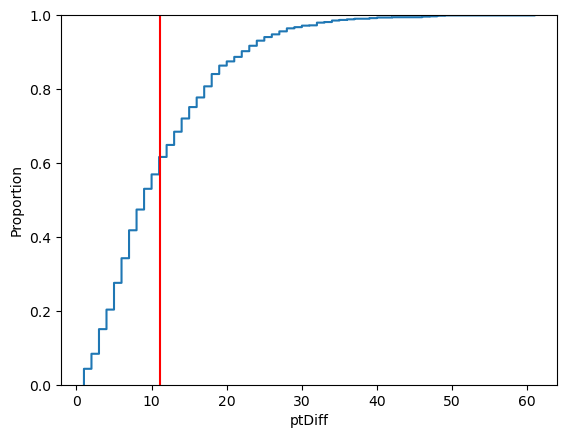

2018-19
count   1230.000
mean      11.739
std        8.779
min        1.000
10%        2.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.400
70%       15.000
80%       19.000
90%       25.000
100%      56.000
max       56.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


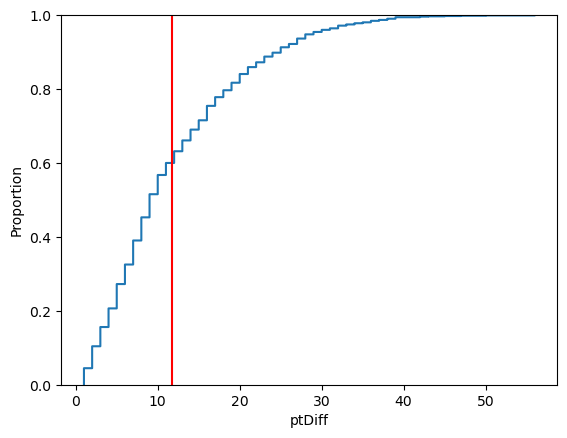

2019-20
count   1059.000
mean      11.413
std        8.535
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.000
70%       14.000
80%       17.000
90%       23.000
100%      49.000
max       49.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


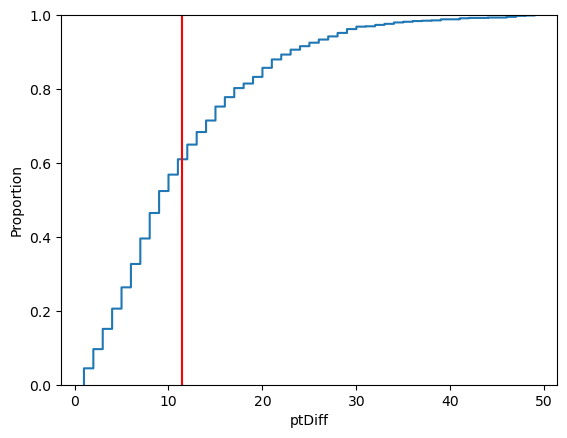

2020-21
count   1080.000
mean      12.184
std        9.103
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       25.000
100%      57.000
max       57.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


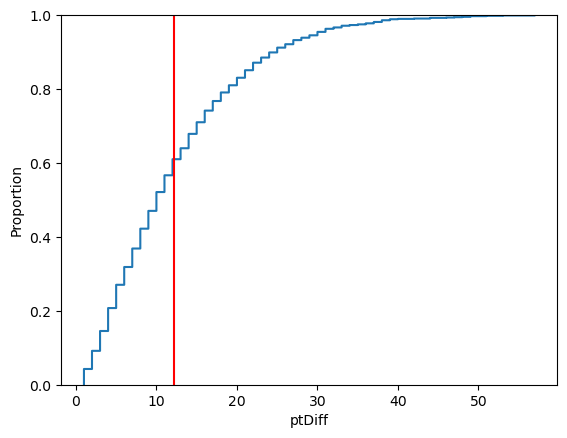

2021-22
count   1230.000
mean      12.373
std        9.176
min        1.000
10%        3.000
20%        5.000
30%        6.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       26.000
100%      73.000
max       73.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


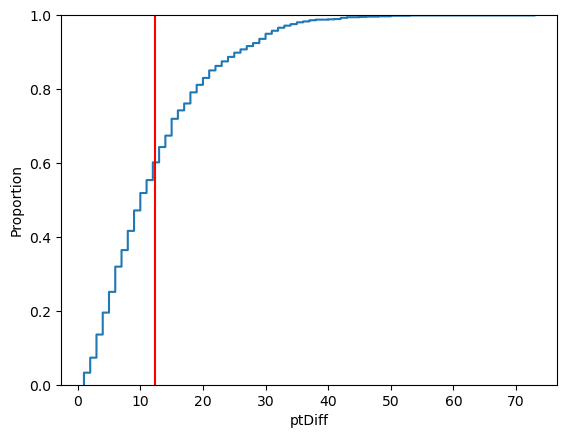

2022-23
count   1230.000
mean      11.181
std        8.245
min        1.000
10%        2.900
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.000
70%       14.000
80%       18.000
90%       22.000
100%      56.000
max       56.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


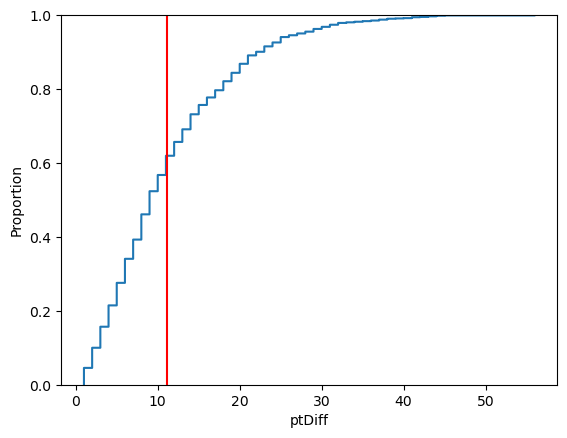

2023-24
count   1230.000
mean      12.584
std        9.529
min        1.000
10%        3.000
20%        5.000
30%        7.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       26.000
100%      62.000
max       62.000
Name: ptDiff, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


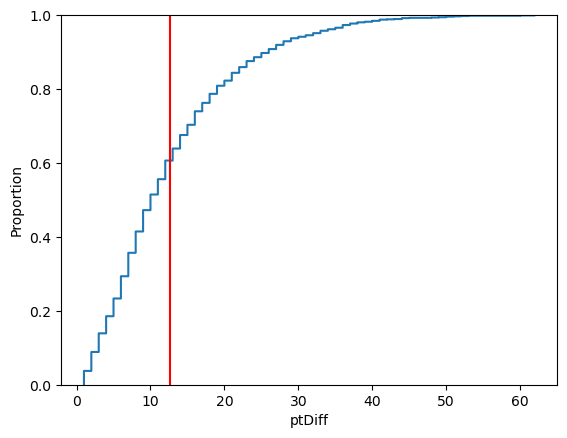

In [126]:
for season in tm.season.unique():
    print(season)
    df = tm[(tm.ptDiff>0) & (tm.season==season)]
    print(df.ptDiff.describe([x/100 for x in range(10,110,10)]))
    sns.ecdfplot(df.ptDiff)
    plt.vlines(x=df.ptDiff.mean(),ymin=0,ymax=1,colors='red')
    plt.show()

In [62]:
#what does 
def pyth_win_exp(pf,pa):
    return np.round(pf ** 16.5 / (pf ** 16.5 + pa ** 16.5),3)

In [192]:
f20 = tm[tm.game_number < 20]
f20wins = f20.groupby(['season','team']).win.value_counts(normalize=True).reset_index()
f20wins = f20wins[f20wins.win==1].drop('win',axis=1)

In [193]:
pyth = pyth_win_exp(tm.groupby(['season','team']).game_points_scored.sum(), tm.groupby(['season','team']).points_allowed.sum()).reset_index(name='pythPerc')

In [194]:
f20wins = f20wins.merge(pyth,how='inner',on=['season','team'])

In [195]:
wPerDf = (tm.groupby(['season','team']).win.sum() / tm.groupby(['season','team']).game_id.nunique()).reset_index(name='actualWPerc')

In [196]:
df = f20wins.merge(wPerDf,how='left',on=['season','team'])

In [197]:
df.actualWPerc

0     0.293
1     0.341
2     0.671
3     0.439
4     0.329
       ... 
205   0.561
206   0.268
207   0.305
208   0.378
209   0.183
Name: actualWPerc, Length: 210, dtype: float64

In [198]:
(df.pythPerc - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean        0.216
std         4.433
min       -13.656
10%        -5.492
20%        -3.164
30%        -1.697
40%        -0.760
50%         0.087
60%         1.243
70%         2.411
80%         4.143
90%         5.554
100%       14.224
max        14.224
dtype: float64

In [199]:
(df.proportion - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean       -0.003
std        10.093
min       -28.113
10%       -11.692
20%        -8.395
30%        -5.905
40%        -2.062
50%        -0.610
60%         1.430
70%         4.846
80%         8.458
90%        13.183
100%       29.020
max        29.020
dtype: float64

In [239]:
linear_model = ols('pythPerc ~ actualWPerc', 
                   data=df).fit() 
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pythPerc   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     2694.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          5.14e-121
Time:                        07:22:54   Log-Likelihood:                 363.74
No. Observations:                 210   AIC:                            -723.5
Df Residuals:                     208   BIC:                            -716.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0366      0.011     -3.393      0.001      -0.058      -0.015
actualWPerc     1.0776      0.021     51.907      0.000       1.037       1.119
==============================================================================
Omnibus:                        1.345   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.007
Skew:                           0.131   Prob(JB):                        0.604
Kurtosis:                       3.216   Cond. No.                         8.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


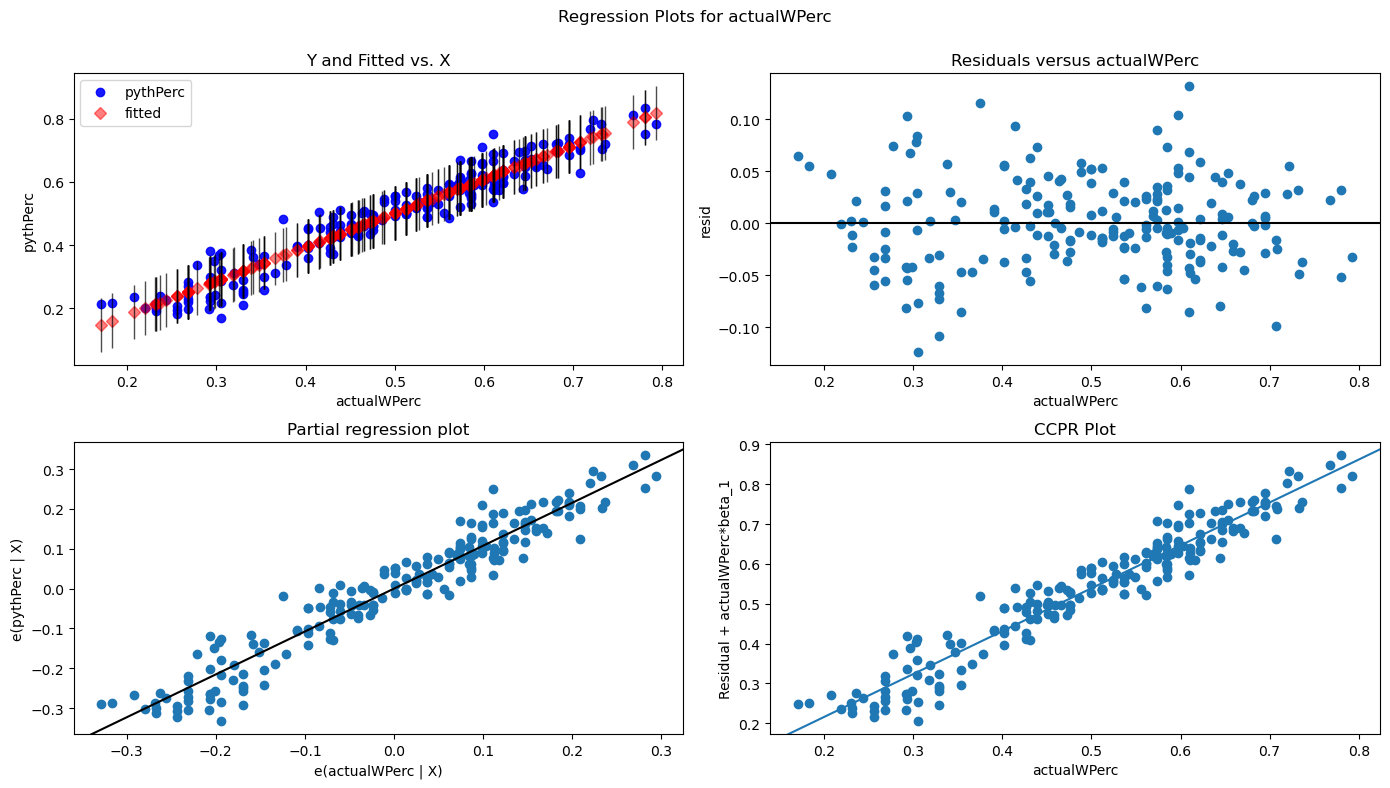

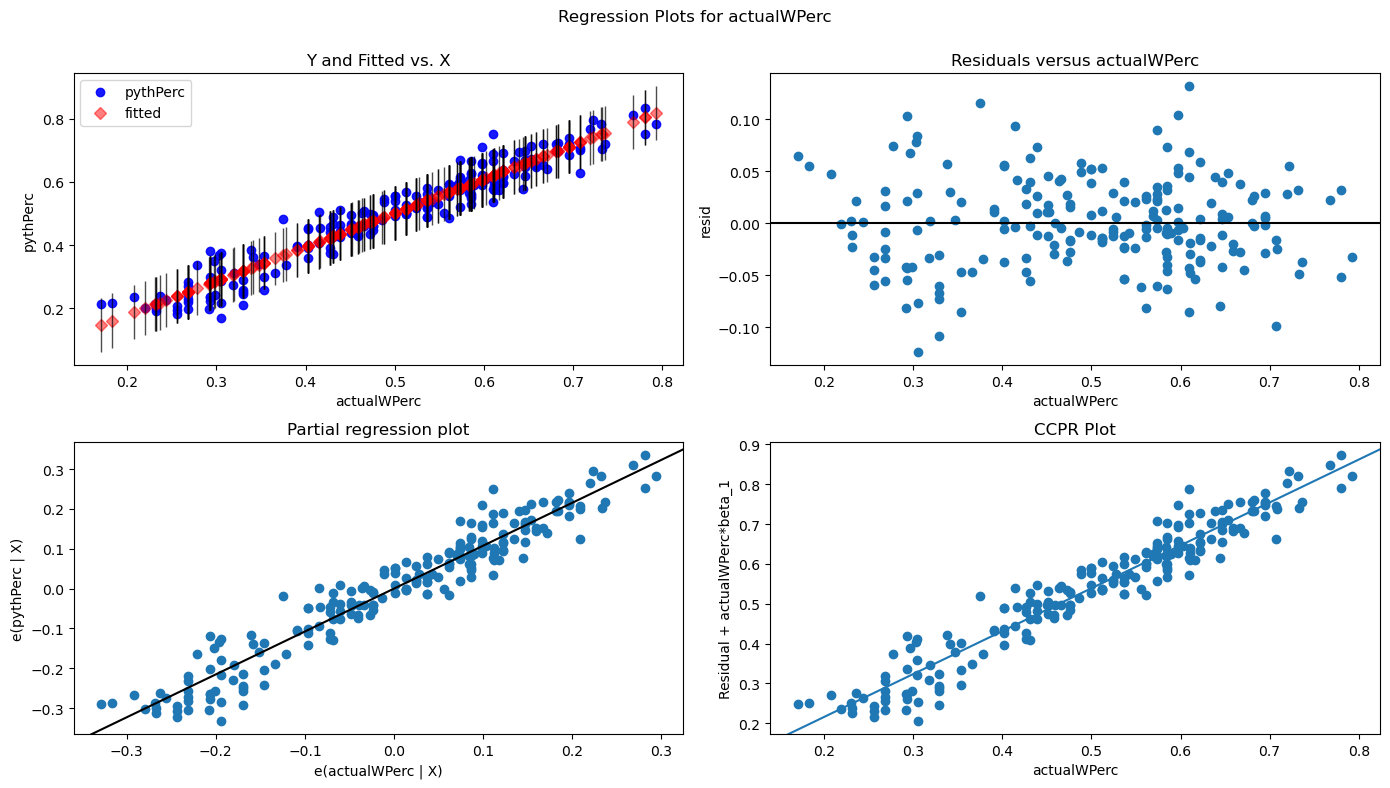

In [240]:
linear_model = ols('pythPerc ~ actualWPerc', 
                   data=df).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'actualWPerc',
                             fig=fig)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


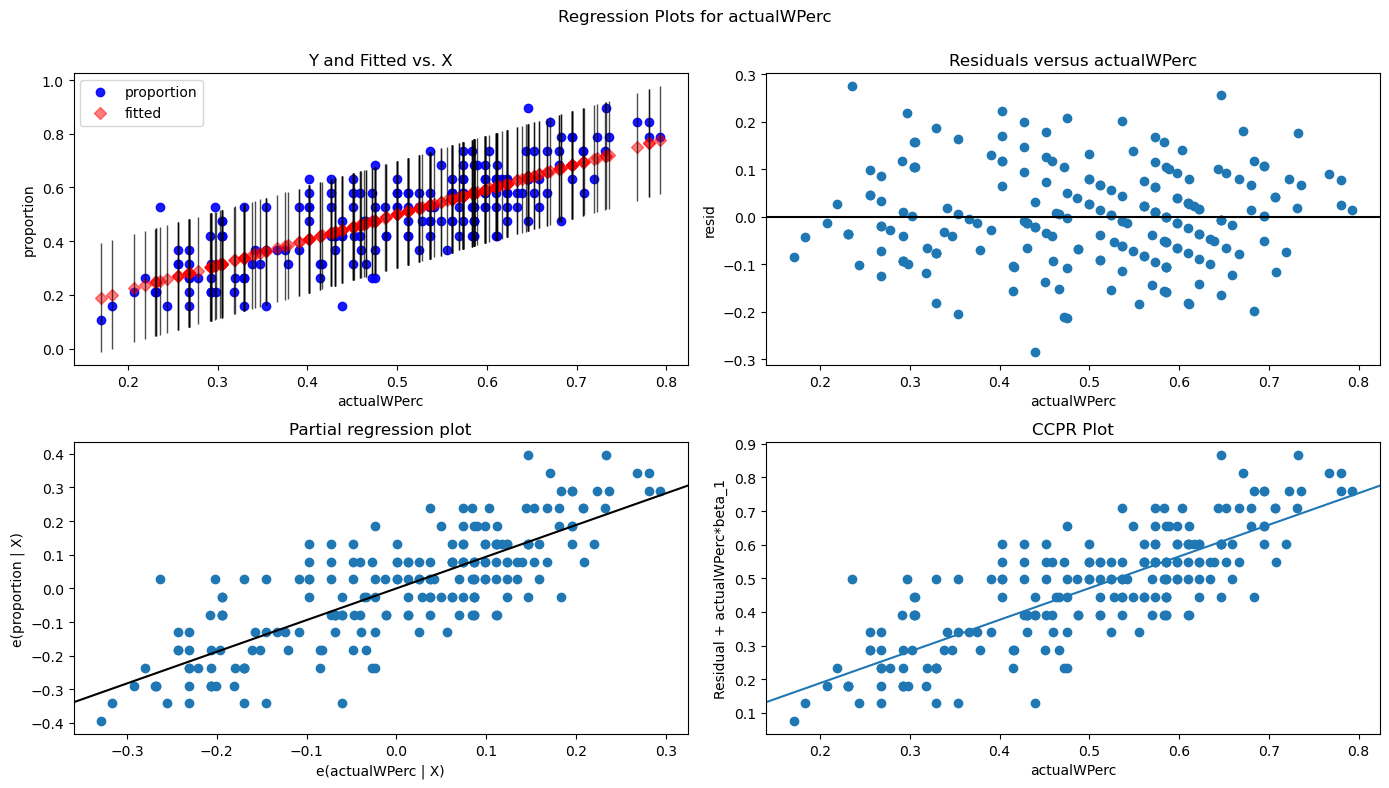

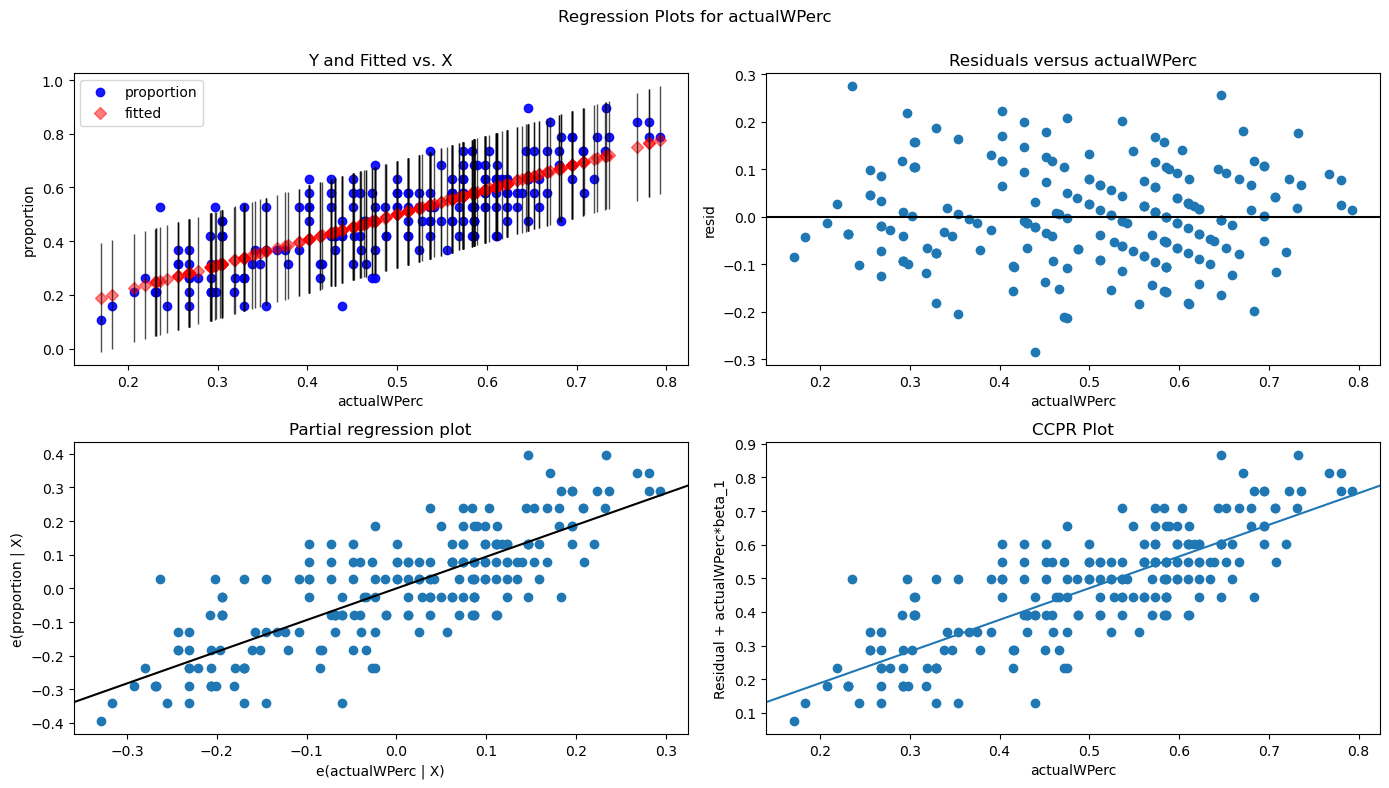

In [202]:
linear_model = ols('proportion ~ actualWPerc', 
                   data=df).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'actualWPerc',
                             fig=fig)

In [187]:
# looking at these it seems that 20 games 

In [130]:
f20['ptDiff'] = f20.game_points_scored - f20.points_allo

/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_1490/2611129655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f20['ptDiff'] = f20.game_points_scored - f20.points_allowed


In [211]:
lg = tm[tm.game_number > 20]

In [216]:
lgw = lg.groupby(['season','team']).win.value_counts(normalize=True).reset_index()
lgw = lgw[lgw.win==1].drop('win',axis=1)

In [218]:
lgw = lgw.rename(columns = {'proportion':'lgWinPerc'})

In [225]:
df = df.merge(lgw,how='left',on=['season','team'])

In [230]:
(df.proportion - df.lgWinPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean        0.050
std        13.352
min       -35.823
10%       -15.986
20%       -11.070
30%        -7.208
40%        -2.997
50%        -0.552
60%         1.868
70%         5.861
80%        11.530
90%        18.039
100%       39.170
max        39.170
dtype: float64

In [231]:
(df.pythPerc - df.lgWinPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean        0.268
std         5.449
min       -13.610
10%        -6.338
20%        -4.470
30%        -3.027
40%        -1.192
50%         0.285
60%         1.802
70%         3.107
80%         4.786
90%         7.505
100%       14.645
max        14.645
dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


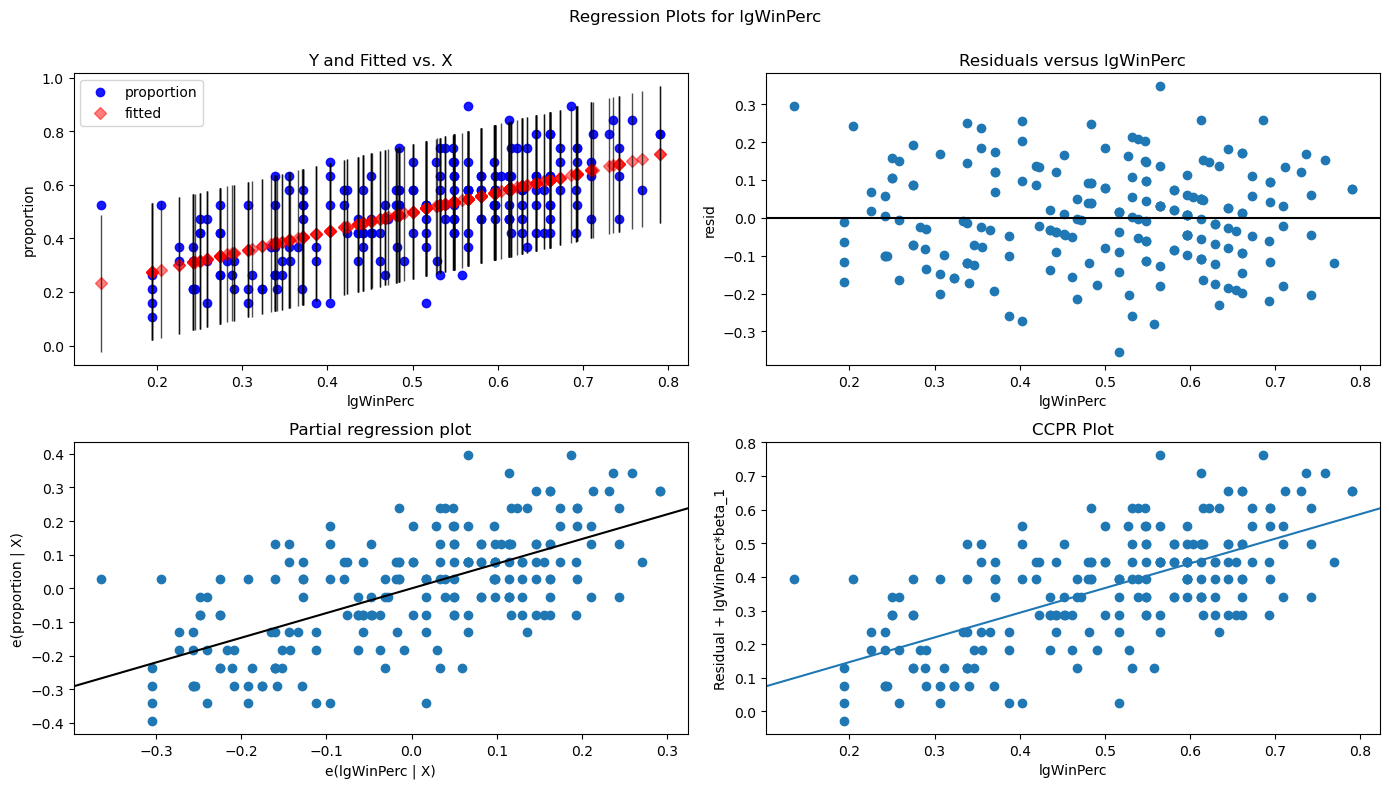

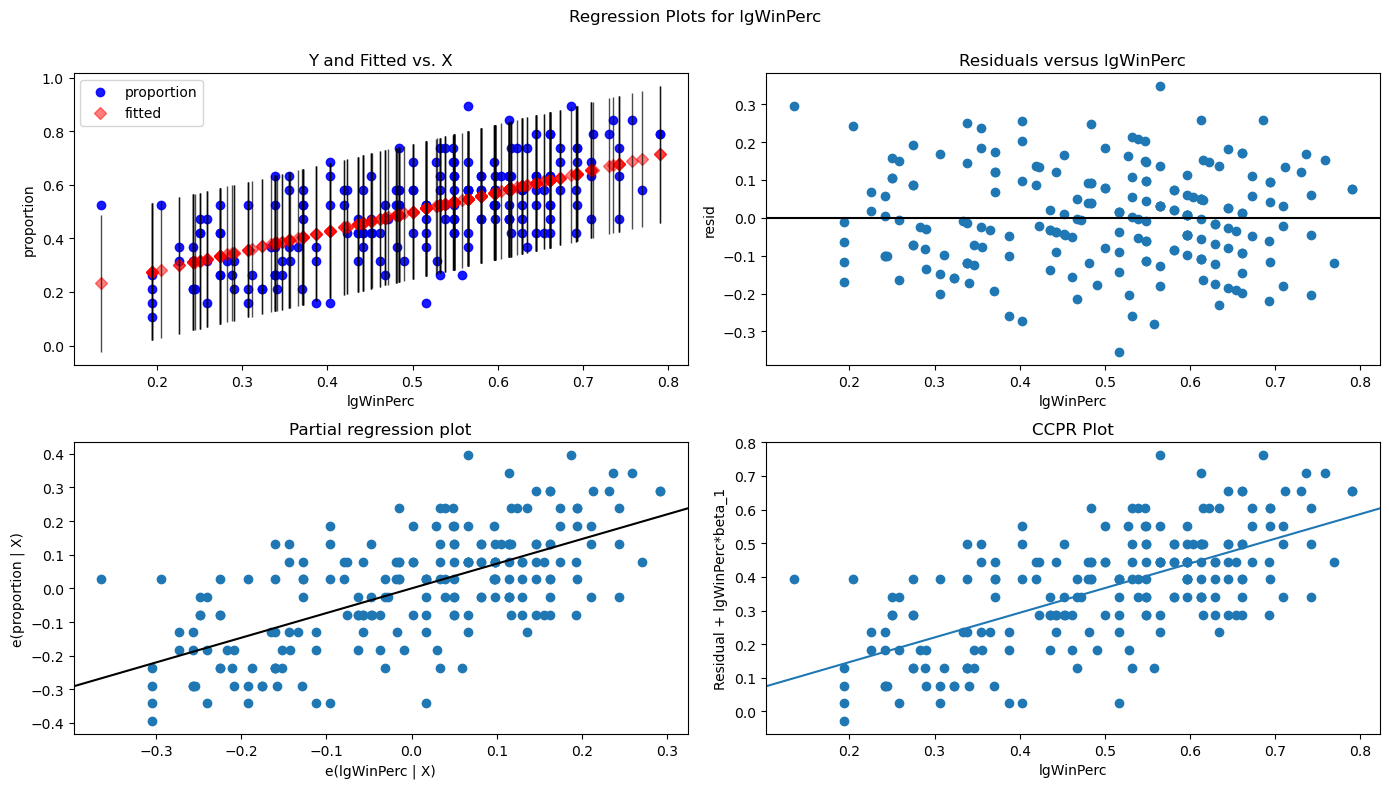

In [237]:
linear_model = ols('proportion ~ lgWinPerc', 
                   data=df).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'lgWinPerc',
                             fig=fig)

In [238]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             proportion   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     154.9
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           6.17e-27
Time:                        07:22:12   Log-Likelihood:                 135.21
No. Observations:                 210   AIC:                            -266.4
Df Residuals:                     208   BIC:                            -259.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1334      0.031      4.347      0.000       0.073       0.194
lgWinPerc      0.7335      0.059     12.444      0.000       0.617       0.850
==============================================================================
Omnibus:                        1.191   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.551   Jarque-Bera (JB):                1.156
Skew:                           0.055   Prob(JB):                        0.561
Kurtosis:                       2.653   Cond. No.                         8.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


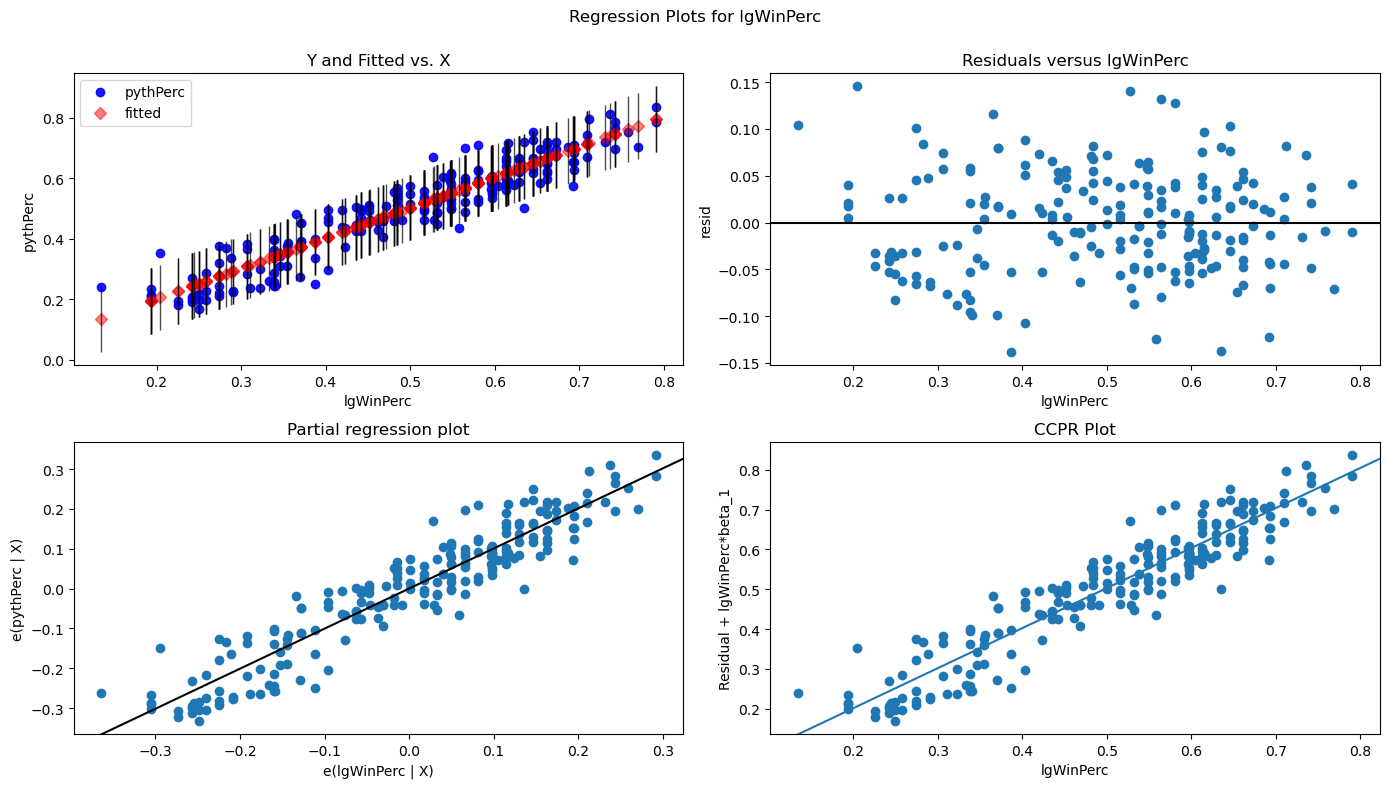

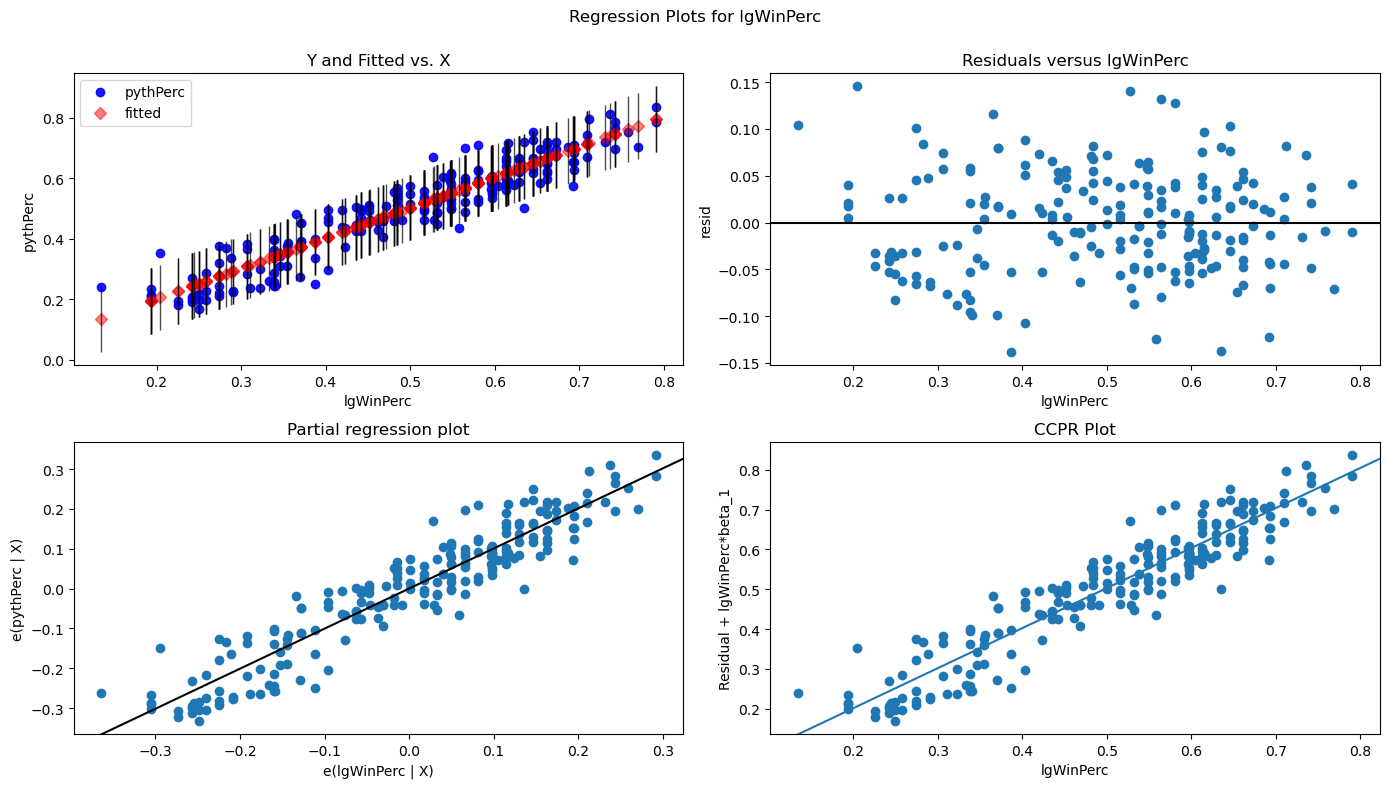

In [232]:
linear_model = ols('pythPerc ~ lgWinPerc', 
                   data=df).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'lgWinPerc',
                             fig=fig)

In [236]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pythPerc   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1592.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           1.97e-99
Time:                        07:21:26   Log-Likelihood:                 313.59
No. Observations:                 210   AIC:                            -623.2
Df Residuals:                     208   BIC:                            -616.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.013     -0.016      0.987      -0.026       0.026
lgWinPerc      1.0058      0.025     39.902      0.000       0.956       1.055
==============================================================================
Omnibus:                        0.487   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.623
Skew:                           0.088   Prob(JB):                        0.732
Kurtosis:                       2.800   Cond. No.                         8.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [254]:
sortedVals = ['10','11','12','01','02','03','04','05']

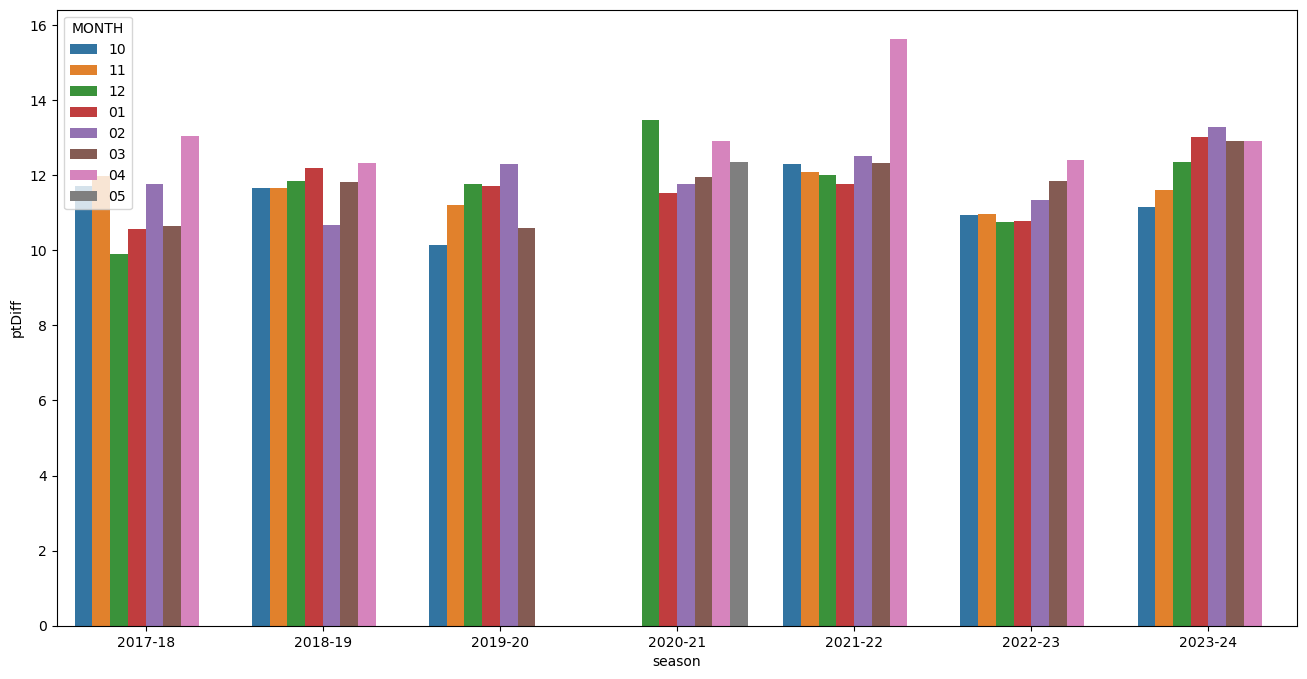

In [257]:

data = tm[tm.win==1].groupby(['season','MONTH']).ptDiff.mean().reset_index()
plt.figure(figsize = (16,8))
sns.barplot(data,x = 'season', y = 'ptDiff',hue='MONTH',hue_order=sortedVals)
plt.show()

 It does seem to increase through the year as april tends to be a high month for spreads.
 2024 there is sentiment that there was a change in refereeing

In [285]:
#win rates at each level of points
tm[(tm.win==1)].ptDiff.describe([x/100 for x in range(0,102,2)])

count   8289.000
mean      11.801
std        8.819
min        1.000
0%         1.000
2%         1.000
4%         1.000
6%         2.000
8%         2.000
10%        3.000
12%        3.000
14%        3.000
16%        4.000
18%        4.000
20%        4.000
22%        5.000
24%        5.000
26%        5.000
28%        6.000
30%        6.000
32%        6.000
34%        7.000
36%        7.000
38%        7.000
40%        8.000
42%        8.000
44%        8.000
46%        9.000
48%        9.000
50%        9.000
52%       10.000
54%       10.000
56%       11.000
58%       11.000
60%       12.000
62%       12.000
64%       13.000
66%       13.000
68%       14.000
70%       15.000
72%       15.000
74%       16.000
76%       17.000
78%       17.000
80%       18.000
82%       19.000
84%       20.000
86%       21.000
88%       22.000
90%       24.000
92%       26.000
94%       28.000
96%       31.000
98%       36.000
100%      73.000
max       73.000
Name: ptDiff, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


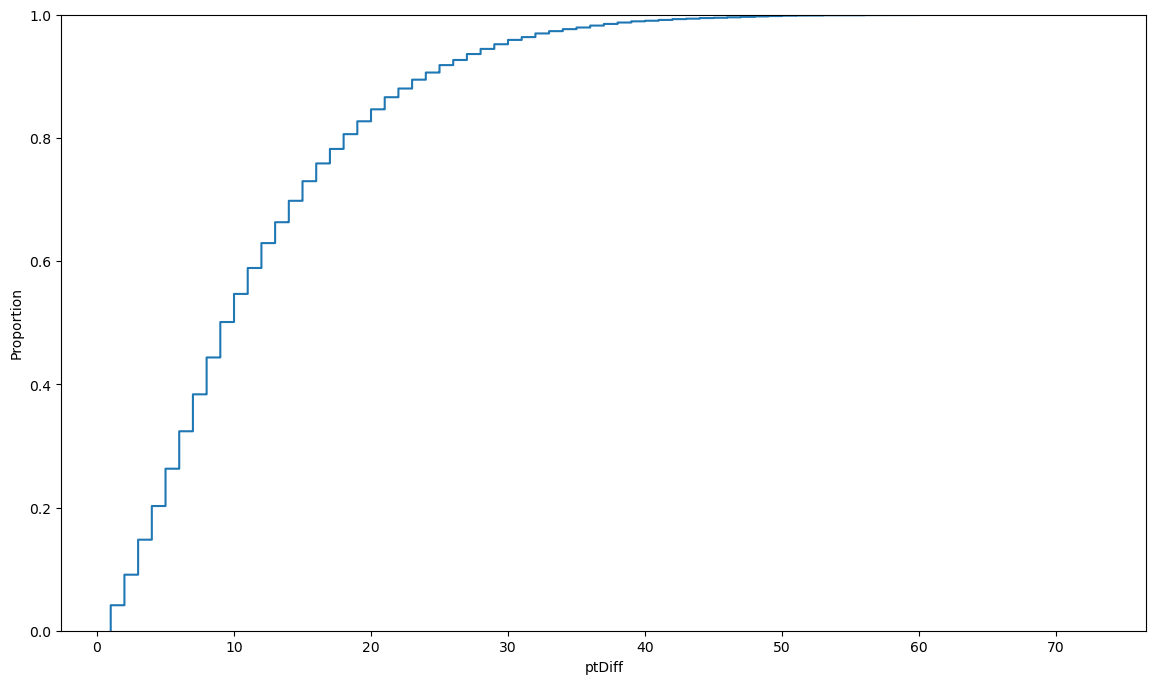

In [281]:
plt.figure(figsize = (14,8))
sns.ecdfplot(tm[(tm.win==1)].ptDiff)
plt.show()

In [287]:
tm[(tm.home==1)].win.value_counts(normalize=True)

win
1   0.563
0   0.437
Name: proportion, dtype: float64

In [291]:
tm[(tm.home==1)].groupby('season').win.sum() / tm.groupby('season').game_id.nunique()

season
2017-18   0.579
2018-19   0.593
2019-20   0.551
2020-21   0.544
2021-22   0.544
2022-23   0.580
2023-24   0.543
dtype: float64

In [295]:
#back-to-backs
print(tm[(tm.daysBetweenGames==0)].win.value_counts(normalize=True))
tm[(tm.daysBetweenGames==0)].groupby('season').win.sum() / tm[(tm.daysBetweenGames==0)].groupby('season').game_id.nunique()

win
0   0.556
1   0.444
Name: proportion, dtype: float64


season
2017-18   0.504
2018-19   0.491
2019-20   0.516
2020-21   0.554
2021-22   0.480
2022-23   0.503
2023-24   0.510
dtype: float64

In [25]:
def update_view(viewName,file):
    nba.conn.execute('DROP VIEW {}'.format(viewName))
    nba.conn.commit()
    nba.conn.execute(open(file,'r').read())
    nba.conn.commit()
    print('{} View has been updated'.format(viewName))

In [21]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
3,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
4,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
5,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
6,view,team_def,team_def,0,"CREATE VIEW team_def AS\nselect \nseason, subs..."
7,view,team_game,team_game,0,"CREATE VIEW team_game as \nSELECT season, game..."
8,view,pgame,pgame,0,"CREATE VIEW pgame AS\nSELECT name,\nseason, su..."


### Want to look through player information will want to build out a clustering for player types


In [46]:
update_view('pseason','data/sql/playerGameView.sql')

pseason View has been updated


In [47]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
3,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
4,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
5,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
6,view,team_def,team_def,0,"CREATE VIEW team_def AS\nselect \nseason, subs..."
7,view,team_game,team_game,0,"CREATE VIEW team_game as \nSELECT season, game..."
8,view,pgame,pgame,0,"CREATE VIEW pgame AS\nSELECT name,\nseason, su..."


In [48]:
plog = pd.read_sql('select * from pseason',nba.conn)

In [49]:
plog.columns

Index(['name', 'team', 'game_number', 'season', 'player_id', 'team_id',
       'game_id', 'game_date', 'min', 'ftm', 'fta', 'reb', 'ast', 'tov', 'stl',
       'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus', 'dd2', 'td3',
       'offensiveRating', 'defensiveRating', 'usagePercentage', 'pace',
       'possessions', 'team_first', 'game_first', 'oreb', 'oreb_contest',
       'oreb_chances', 'oreb_chance_defer', 'avg_oreb_dist', 'dreb',
       'dreb_contest', 'dreb_chances', 'dreb_chance_defer', 'avg_dreb_dist',
       'ra_fgm', 'ra_fga', 'paint_fga', 'paint_fgm', 'mid_fgm', 'mid_fga',
       'lc_fgm', 'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga'],
      dtype='object')

In [6]:
## There are 350 undrafted players, Fred van leet is the only all-star, I dont think missing exp will matter too much for them
test = pd.read_sql('''select * from players where pick = 'Undrafted' ''',nba.conn)

In [14]:
#lets see how offensive/defensive and net rating look for the top 50 players
#need to get a yearly offensive rating

,player_id,name,height,weight,pos,draft_year,pick,birthday,allstars,allnba_first,allnba_second,allnba_third,alld_first,alld_second,mip,dpoy,mvp,finals_mvp
318,1627832,Fred VanVleet,72,197,Guard,Undrafted,Undrafted,1994-02-25,2021-22,None,None,None,None,None,None,None,None,None


In [45]:
plog.

In [59]:
testRate = plog[['name','season','offensiveRating','possessions']]

In [74]:
offFac = testRate.offensiveRating * 

In [75]:
testRate['offFac'] = offFac

/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_10504/2520404280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testRate['offFac'] = offFac


In [76]:
testRate.groupby(['name','season']).offFac.sum().reset_index()

,name,season,offFac
0,A.J. Lawson,2022-23,1.820
1,A.J. Lawson,2023-24,5.490
2,AJ Green,2022-23,7.080
3,AJ Green,2023-24,8.720
4,AJ Griffin,2022-23,31.751
...,...,...,...
3761,Zion Williamson,2019-20,16.311
3762,Zion Williamson,2020-21,48.628
3763,Zion Williamson,2022-23,23.599
3764,Zion Williamson,2023-24,43.971


In [58]:
testRate[testRate.name=='Nikola Jokic'].groupby('season').offFac.mean()

season
2017-18   75.733
2018-19   72.799
2019-20   73.522
2020-21   84.577
2021-22   81.380
2022-23   87.695
2023-24   86.133
Name: offFac, dtype: float64

In [ ]:
testRate.grouopby(['name','season']).